# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model-hac'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=torch.float)
setup

Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.user.num_data_points = 100
cfg.case.server.model_modification.type = 'HonestAbandonCuriosity' 
cfg.case.server.model_modification.num_bins = 1000
cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'addition'

cfg.case.data.normalize = False
cfg.case.server.model_modification.mu = 0 # -0.4490 # imagenet mean
cfg.case.server.model_modification.sigma = 0.5 # / 0.2260 # divide by std
cfg.case.server.model_modification.scale_factor = 1 - 0.990

cfg.attack.breach_reduction = None # Will be done manually

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

model.conv1
Block inserted at feature shape torch.Size([3, 224, 224]).
(tensor(0.3536), tensor(-2.9128e-05))
Model architecture ResNet18 loaded with 161,909,173 parameters and 9,620 buffers.
Overall this is a data ratio of      11:1 for target shape [100, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 100

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': torch.Size([3, 224, 224]), 'structure': 'sparse'}}
    
Attacker (of type ImprintAttacker).


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update in model mode: eval.


In [6]:
#grads = shared_data['gradients'][0]
#[(g.norm(), g.mean(), g.std()) for g in grads]

In [7]:
#torch.norm(torch.stack([torch.norm(g, 2) for g in grads]), 2)

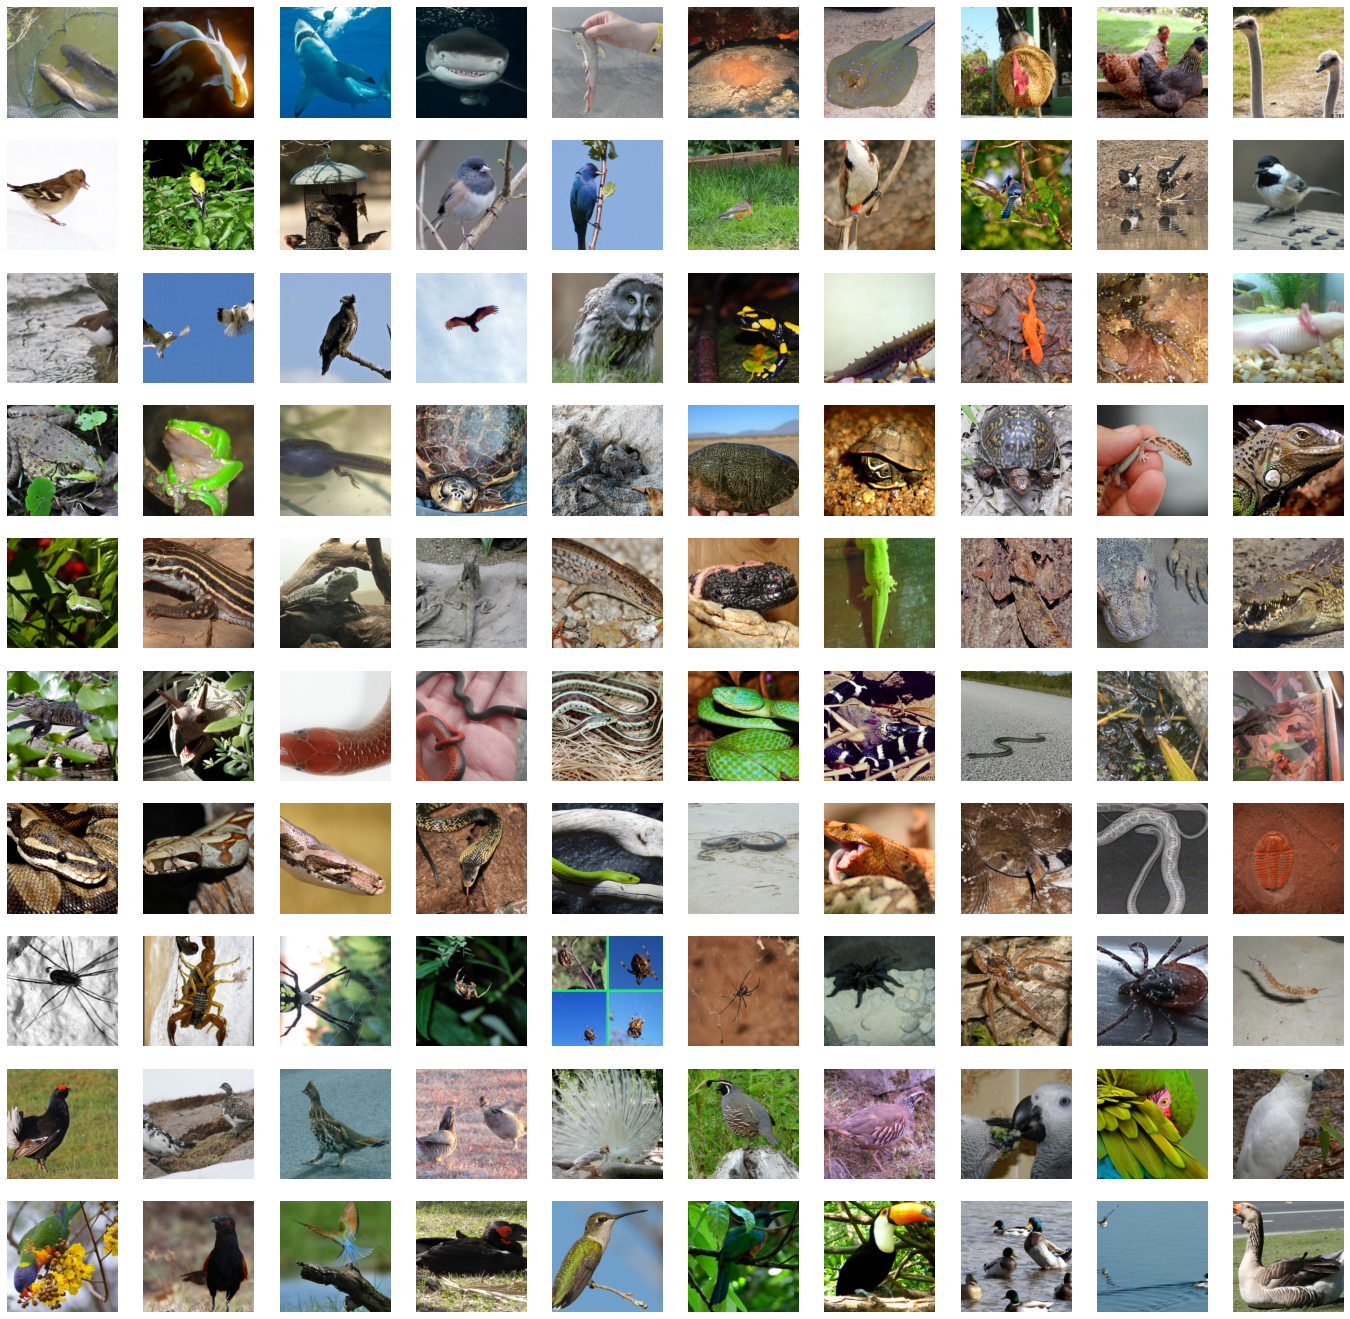

In [8]:
user.plot(true_user_data)

# Reconstruct user data

In [9]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

Initially produced 949 hits.


In [10]:
# user.plot(reconstructed_user_data) # Raw ~num bins outputs

### Remove mixed images by direct GT comparison

In [11]:
reconstructed = torch.zeros_like(true_user_data["data"])
for sample in reconstructed_user_data["data"]:
        l2_dists = (sample[None] - true_user_data["data"]).pow(2).mean(dim=[1, 2, 3])
        min_dist, min_idx = l2_dists.min(dim=0)
        if min_dist < 1e-1:
            reconstructed[min_idx] = sample
reconstructed_user_data = dict(data=reconstructed, labels=None)

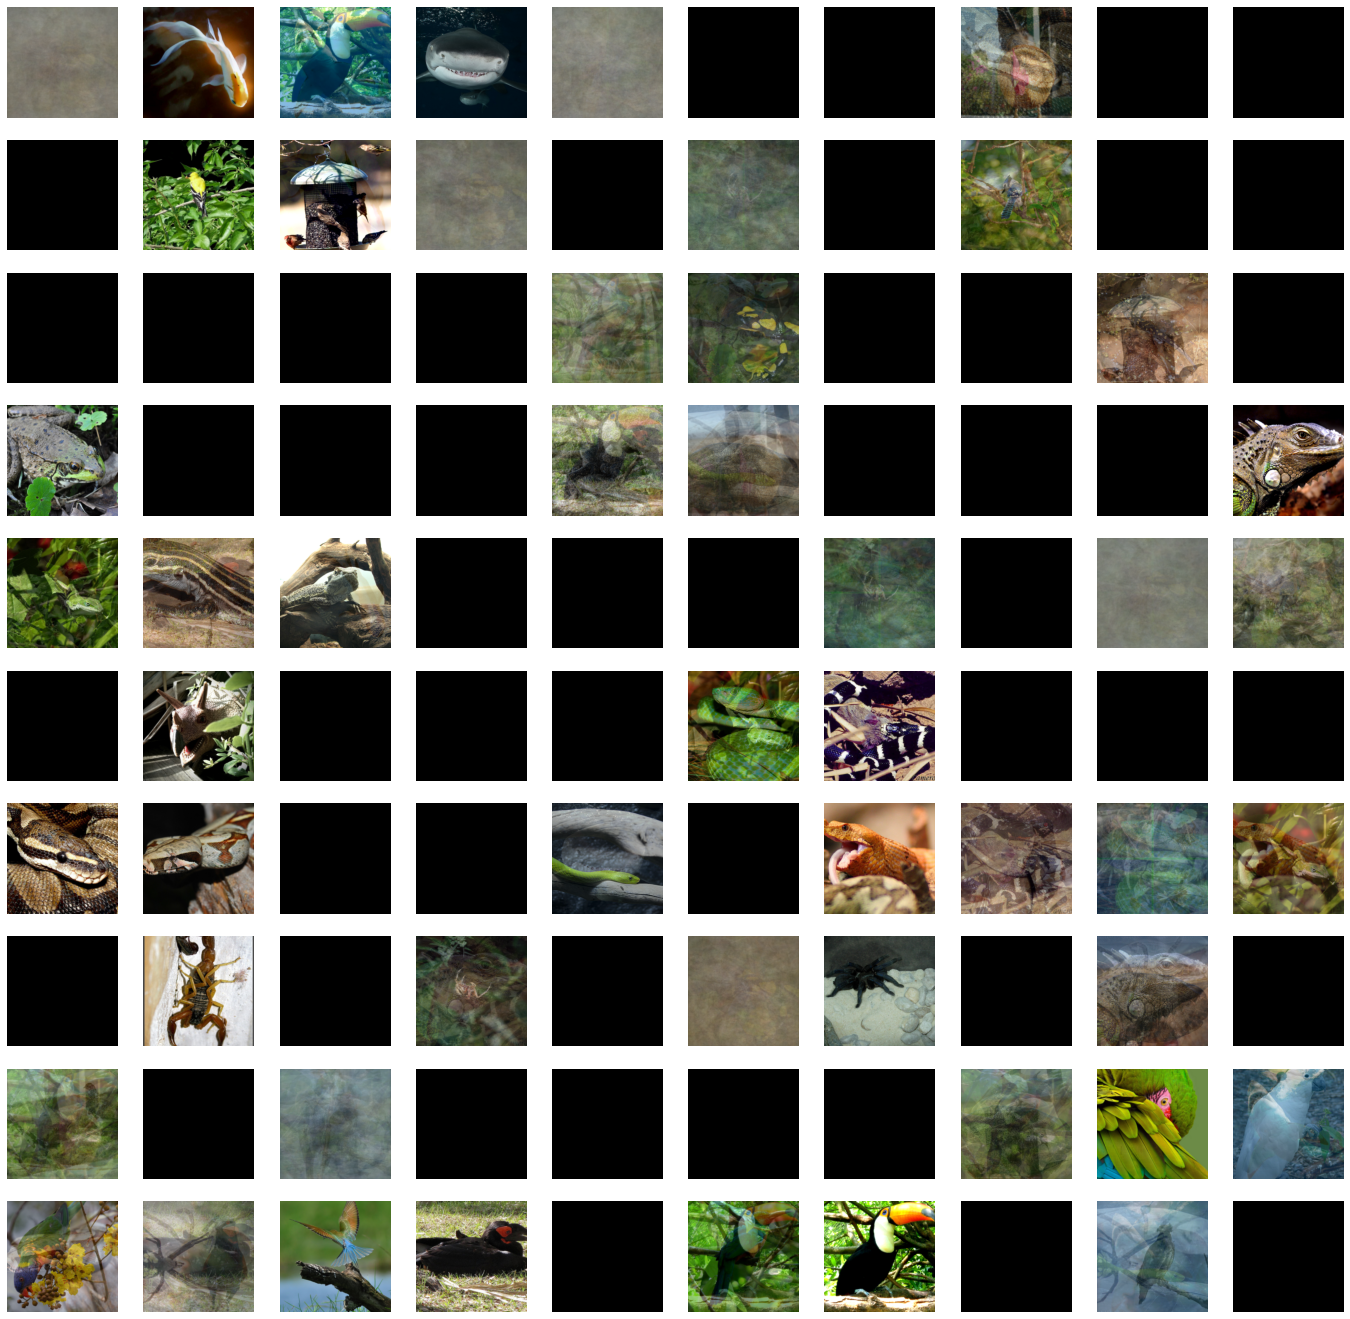

In [12]:
user.plot(reconstructed_user_data)

### Evaluate Metrics

In [13]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0083 | PSNR: 42.52 | FMSE: 1.2242e+02 | LPIPS: 0.42|
 R-PSNR: 42.92 | IIP-pixel: 32.00% | SSIM: 0.3500 | max R-PSNR: 181.57 | max SSIM: 1.0000 | Label Acc: 0.00%


In [14]:
# Should be 40% from the paper, but is only 20% uniques?